In [ ]:
import pandas as pd
import requests
import time
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import plotly.express as px
import os

In [ ]:
region_df = pd.read_csv("src/S3_regions_codes_and_names_v2021.csv")

In [14]:
region_df["Country code"] = region_df["Code"].apply(lambda x : x[:2])

In [ ]:
flood_df = pd.read_csv("src/HANZE_events.csv")

In [24]:
country_codes_df = flood_df.loc[:,["Country code", "Country name"]].drop_duplicates().reset_index()

In [27]:
region_df = pd.merge(region_df, country_codes_df, on='Country code', how='left')

In [ ]:
Google_API_key = os.getenv("Google_API_KEY")
def geocode_region(name, country_name):
    # Construct the query with region name and country code
    query = f"{name} {country_name}"
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={query}&key={Google_API_key}"
    response = requests.get(url)
    
    if response.status_code == 200:
        results = response.json()
        if results['status'] == 'OK':  # Check if the request was successful
            location = results['results'][0]['geometry']['location']
            return location['lat'], location['lng']
        else:
            print(f"Geocoding failed for {query}. Status: {results['status']}")
    else:
        print(f"HTTP request failed for {query}. Status code: {response.status_code}")
    
    return None, None

In [29]:
for index, row in region_df.iterrows():
    country_code = row['Code'][:2]  # Extract the first two characters as the country code
    lat, lon = geocode_region(row['Name'], row["Country name"])
    region_df.at[index, 'Latitude'] = lat
    region_df.at[index, 'Longitude'] = lon
    time.sleep(0.05) 


Geocoding failed for Caithness & Sutherland and Ross & Cromarty United Kingdom. Status: ZERO_RESULTS


In [37]:
region_df

,Code,Name,Country code,Country name,Latitude,Longitude
0,AD000,Andorra,AD,Andorra,42.506285,1.521801
1,AL011,Dibër,AL,Albania,41.588816,20.235565
2,AL012,Durrës,AL,Albania,41.324590,19.456469
3,AL013,Kukës,AL,Albania,42.075584,20.425946
4,AL014,Lezhë,AL,Albania,41.786073,19.646076
...,...,...,...,...,...,...
1438,XK006,Gjilan/Gnjilane,XK,Kosovo,42.388746,21.427589
1439,XK002,Mitrovicë/Mitrovica,XK,Kosovo,42.994799,20.807608
1440,XK003,Pejë/Peć,XK,Kosovo,42.720918,20.473876
1441,XK001,Prishtinë/Priština,XK,Kosovo,42.669461,21.141423


In [38]:
region_df.loc[region_df["Name"] == "Caithness & Sutherland and Ross & Cromarty", ['Latitude', 'Longitude']] = 57.948211, -4.436254

In [42]:
px.scatter_map(region_df, lat="Latitude", lon="Longitude", hover_name="Name", hover_data="Code")

In [43]:
region_df.loc[region_df["Name"] == "Kensington & Chelsea and Hammersmith & Fulham", ['Latitude', 'Longitude']] = 51.499399, -0.215796
region_df.loc[region_df["Name"] == "Perth & Kinross and Stirling", ['Latitude', 'Longitude']] = 56.208394, -3.436359

In [99]:
# Load a global dataset of oceans/seas (Natural Earth dataset)
coastline_gpd = gpd.read_file("src/worlds-coastline_808.geojson")


In [100]:
coastline_gpd

,scalerank,featureclass,geometry
0,0,Ocean,"POLYGON ((49.11029 41.28229, 48.58447 41.8089,..."
1,0,Ocean,"POLYGON ((180 71.51571, 178.7253 71.0988, 178...."


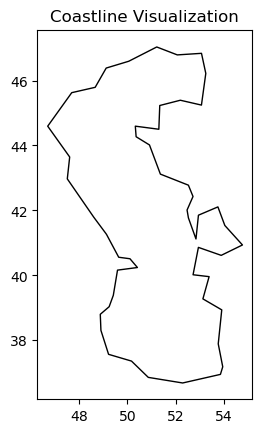

In [101]:
coastline_gpd.drop(1).plot(edgecolor='black', facecolor='white')
plt.title("Coastline Visualization")
plt.show()

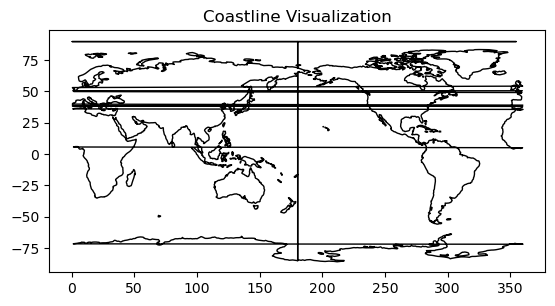

In [102]:
coastline_gpd.drop(0).plot(edgecolor='black', facecolor='white')
plt.title("Coastline Visualization")
plt.show()

In [103]:
coastline_gpd.drop(0, inplace=True)

In [104]:
coastline_gpd.geometry = coastline_gpd.geometry.to_crs(epsg=3035)
coastline_geo = coastline_gpd.geometry

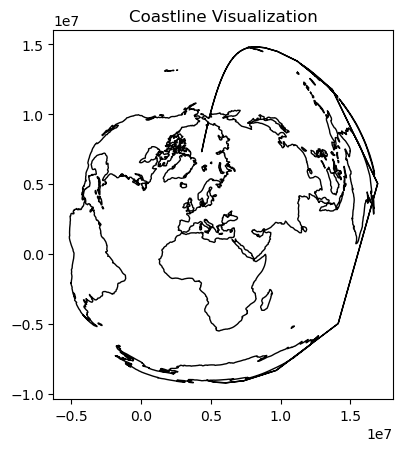

In [105]:
coastline_gpd.plot(edgecolor='black', facecolor='white')
plt.title("Coastline Visualization")
plt.show()

In [106]:
# Define the input location (lat, lon)
lat, lon = 48.858844, 2.294351  # Example: Eiffel Tower, France
point = Point(lon, lat)
point = gpd.GeoSeries([point], crs='EPSG:4326').to_crs(epsg=3035).iloc[0]
# Find the closest ocean/sea
a = coastline_geo.exterior.interpolate(coastline_geo.exterior.project(point))

print(f"Closest Ocean/Sea: {a}")

Closest Ocean/Sea: 1    POINT (3703258.087 3038204.321)
dtype: geometry


c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


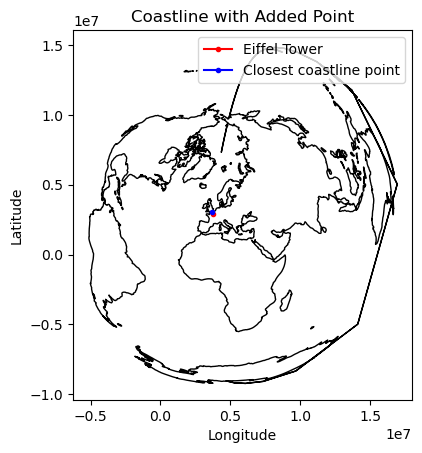

In [ ]:
ax = coastline_gpd.plot(edgecolor='black', facecolor='white')

# Plot the point on top of the coastline
plt.plot(point.x, point.y, color='red', marker='o', markersize=3, label='Eiffel Tower')
closest_coastline_point = a.iloc[0]
plt.plot(closest_coastline_point.x, closest_coastline_point.y, color='blue', marker='o', markersize=3, label='Closest coastline point')

plt.legend()

plt.title("Coastline with Added Point")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [109]:
def Getclosest_coast_point(row):
    # Extract latitude and longitude from the row
    lat, lon = row["Latitude"], row["Longitude"]
    point = Point(lon, lat)
    
    # Reproject the point to a projected CRS
    point_proj = gpd.GeoSeries([point], crs='EPSG:4326').to_crs(epsg=3035).iloc[0]
    
    # Find the closest point on the coastline
    closest_coastline_point_proj = coastline_geo.exterior.interpolate(
        coastline_geo.exterior.project(point_proj)
    ).iloc[0]
    # Reproject closest point back to EPSG:4326
    closest_coastline_point_geo = gpd.GeoSeries([closest_coastline_point_proj], crs='EPSG:3035').to_crs(epsg=4326).iloc[0]
    
    # Add calculated values to the row
    row["Sea distance"] = closest_coastline_point_proj.distance(point_proj)
    row["Sea latitude"] = closest_coastline_point_geo.y  # Latitude
    row["Sea longitude"] = closest_coastline_point_geo.x  # Longitude
    return row

region_df = region_df.apply(Getclosest_coast_point, axis=1)

c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\ad98\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_

In [110]:
region_df

,Code,Name,Country code,Country name,Latitude,Longitude,Sea distance,Sea latitude,Sea longitude
0,AD000,Andorra,AD,Andorra,42.506285,1.521801,120770.942754,42.473083,2.986084
1,AL011,Dibër,AL,Albania,41.588816,20.235565,59744.477832,41.720093,19.540100
2,AL012,Durrës,AL,Albania,41.324590,19.456469,5300.276600,41.329600,19.393639
3,AL013,Kukës,AL,Albania,42.075584,20.425946,83896.952278,41.720093,19.540100
4,AL014,Lezhë,AL,Albania,41.786073,19.646076,11519.642694,41.721554,19.538546
...,...,...,...,...,...,...,...,...,...
1438,XK006,Gjilan/Gnjilane,XK,Kosovo,42.388746,21.427589,173918.837445,41.720093,19.540100
1439,XK002,Mitrovicë/Mitrovica,XK,Kosovo,42.994799,20.807608,172101.299510,41.877686,19.371887
1440,XK003,Pejë/Peć,XK,Kosovo,42.720918,20.473876,131094.251710,41.877686,19.371887
1441,XK001,Prishtinë/Priština,XK,Kosovo,42.669461,21.141423,170035.123026,41.729881,19.529686


In [114]:
px.scatter_map(region_df, lat="Sea latitude", lon="Sea longitude", hover_name="Name", hover_data="Code")

In [111]:
region_df.to_csv("output/regions_codes_names_and_coords.csv", index=False)